# Set up a spmf


In [32]:
import os


def generate_patterns_spade(
    input_file="spmf_input.txt",
    output_file="spmf_output.txt",
    minsup="50%",
    mine_only_closed_patterns="false",
):
    os.system(
        f"java -jar /home/ybrus/gha_workflows/granularity_exploration/spmf.jar run CM-SPADE {input_file} {output_file} {minsup} {mine_only_closed_patterns}"
    )
    # os.system(
    #     f"java -jar /home/ybrus/gha_workflows/granularity_exploration/spmf.jar run GSP {input_file} {output_file} {minsup} {mine_only_closed_patterns}"
    # )
    # os.system(
    #     f"java -jar /home/ybrus/gha_workflows/granularity_exploration/spmf.jar run PrefixSpan {input_file} {output_file} {minsup} 20 {mine_only_closed_patterns}"
    # )
    # os.system(
    #     f"java -jar /home/ybrus/gha_workflows/granularity_exploration/spmf.jar run SPADE {input_file} {output_file} {minsup} {mine_only_closed_patterns}"
    # )

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def create_spmf_input_file(gha_workflow_sequences, file_name):
    item_map = {}
    mapped_sequences = []
    item_counter = 1

    for gha_workflow_sequence in gha_workflow_sequences:
        sequence = gha_workflow_sequence["sequence"]
        mapped_sequence = []

        for item in sequence:
            if item not in item_map:
                item_map[item] = item_counter
                item_counter += 1
            mapped_sequence.append(str(item_map[item]))

        mapped_sequences.append(" -1 ".join(mapped_sequence))
    # display(item_map)
    # plot_commands(item_map)
    with open(file_name, "w") as f:
        f.write("@CONVERTED_FROM_TEXT\n")
        for key, value in item_map.items():
            f.write(f"@ITEM={value}={key}\n")

        f.write("@ITEM=-1=|\n")
        for sequence in mapped_sequences:
            if sequence:
                f.write(sequence + " -1 -2\n")

# Yaml files proccessing


In [3]:
import ruamel.yaml


def get_parsed_yaml_data(file_path):
    yaml = ruamel.yaml.YAML(typ="safe")
    with open(file_path, "r") as file:
        try:
            workflow_data = yaml.load(file)
            return workflow_data
        except:
            return
            print(file_path)
            print(workflow_data)


def extract_triggers(file_path):
    yaml = ruamel.yaml.YAML(typ="safe")
    with open(file_path, "r") as file:
        try:
            workflow_data = yaml.load(file)
            triggers = workflow_data.get("on", {})
            return triggers
        except:
            return
            print(file_path)
            print(workflow_data)


def extract_jobs_uses(file_path):
    yaml = ruamel.yaml.YAML(typ="safe")
    with open(file_path, "r") as file:
        try:
            workflow_data = yaml.load(file)
            # print(workflow_data)
            jobs = workflow_data.get("jobs", {})
            return jobs
        except:
            return
            print(file_path)
            print(workflow_data)


def extract_workflow_name(file_path):
    yaml = ruamel.yaml.YAML(typ="safe")
    with open(file_path, "r") as file:
        try:
            workflow_data = yaml.load(file)
            # print(workflow_data)
            workflow_name = workflow_data.get("name", "")
            return workflow_name
        except:
            return
            print(file_path)
            print(workflow_data)

# Process workflows


In [4]:
import os

gha_workflow_sequences = []
directory = "/home/ybrus/gha_workflows/workflows_latest"
len(os.listdir(directory))

149941

In [ ]:
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)

    if os.path.isfile(file_path):
        try:
            triggers = extract_triggers(file_path)
            jobs = extract_jobs_uses(file_path)
            if jobs:
                for job_name, job_info in jobs.items():
                    sequence = []

                    if job_info.get("uses", ""):
                        sequence.append(job_info["uses"])
                    for step in job_info.get("steps", []):
                        if step.get("uses", ""):
                            sequence.append(step["uses"].split("@")[0])
                        if step.get("run", ""):
                            for run_command in step["run"].split("\n"):
                                if run_command:
                                    sequence.append(run_command)

                sequence_metadata = {
                    "file": filename,
                    "file_path": file_path,
                    "job_name": job_name,
                    "sequence": sequence,
                    "triggers": triggers,
                }
                gha_workflow_sequences.append(sequence_metadata)
        except Exception as error:
            print("ERROR:")
            print(error)

# Preprocessing, abstaction of custom elements


In [40]:
import os
import subprocess
import re

import comm


def change_links_to_keyword(text):
    url_pattern = r"(https?://\S+)"
    return re.sub(url_pattern, "URL", text)


def change_paths_to_keyword(text):
    dir_pattern = r"(\s?\/[^\s]+\/?)"
    file_pattern = r"(\s?\/[^\s]+\.[a-zA-Z]+)"
    text = re.sub(file_pattern, " CUSTOM_PATH_FILE", text)
    text = re.sub(dir_pattern, " CUSTOM_PATH_DIR", text)
    return text


def remove_versions(text):
    version_pattern = r"(@[0-9A-Za-z\-\.]+)"
    return re.sub(version_pattern, "", text)


def change_flags_to_keyword(text):
    flag_pattern = r"(--[a-zA-Z0-9\-]+)"
    return re.sub(flag_pattern, "FLAG", text)


def change_env_vars_to_keyword(text):
    env_var_pattern = r"(\$\{?[A-Z_]+\}?)"
    return re.sub(env_var_pattern, "ENV_VAR", text)


# def change_dynamic_variables(text):
#     variable_pattern = r"(\$[a-zA-Z0-9_]+)"
#     return re.sub(variable_pattern, "VARIABLE", text)


def change_commit_message(text):
    commit_pattern = r'(git commit -m\s+")(.*?)(\")'
    return re.sub(commit_pattern, r'git commit -m "COMMIT_MSG"', text)


def abstract_echo(text):
    echo_pattern = r'(echo\s+")(.*?)(\")'
    return re.sub(echo_pattern, r'echo "ECHO_MSG"', text)


def preprocess_command(command):
    command = change_links_to_keyword(command)
    command = change_paths_to_keyword(command)
    command = remove_versions(command)
    command = change_flags_to_keyword(command)
    command = change_env_vars_to_keyword(command)
    # command = change_dynamic_variables(command)
    command = change_commit_message(command)
    command = abstract_echo(command)
    return command

In [ ]:
import os
from collections import defaultdict

all_run_commands = 0
multiline_run_commands = 0
multiline_run_commands_with_space = 0

gha_workflow_sequences = []
directory = "/home/ybrus/gha_workflows/workflows_latest"

commands_count = defaultdict(int)


def process_run_commands(run_commands, commands_count):
    sequence = []
    is_multiline = len(run_commands) > 1

    # if is_multiline:
    #     multiline_run_commands += 1
    # else:
    #     all_run_commands += 1

    for run_command in run_commands:
        if run_command.startswith(" "):
            # multiline_run_commands_with_space += 1
            return []

    for run_command in run_commands:
        if run_command and not run_command.startswith("# "):
            changed_run_command = preprocess_command(run_command)
            sequence.append(changed_run_command)
            commands_count[changed_run_command] += 1

    return sequence


def process_steps(steps, commands_count):
    sequence = []

    for step in steps:
        if "uses" in step:
            uses_command = "USES: " + step["uses"].split("@")[0]
            sequence.append(uses_command)
            commands_count[uses_command] += 1

        if "run" in step:
            run_commands = step["run"].split("\n")
            # sequence.extend(process_run_commands(run_commands, commands_count))
            run_sequence = process_run_commands(run_commands, commands_count)
            if run_sequence:
                sequence.extend(run_sequence)

    return sequence


def process_jobs(jobs, commands_count):
    sequences = []

    for job_name, job_info in jobs.items():
        sequence = []

        if "uses" in job_info:
            sequence.append(job_info["uses"])

        if "steps" in job_info:
            sequence.extend(process_steps(job_info["steps"], commands_count))

        if sequence:
            sequences.append({"job_name": job_name, "sequence": sequence})

    return sequences


def process_workflow_file(file_path, commands_count):
    try:
        triggers = extract_triggers(file_path)
        jobs = extract_jobs_uses(file_path)
        if jobs:
            job_sequences = process_jobs(jobs, commands_count)
            return [
                {"file_path": file_path, "triggers": triggers, **job}
                for job in job_sequences
            ]
    except Exception as error:
        print(f"ERROR processing file {file_path}: {error}")
    return []


for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)

    if os.path.isfile(file_path):
        sequences = process_workflow_file(file_path, commands_count)
        gha_workflow_sequences.extend(sequences)

print(f"Total single-line run commands: {all_run_commands}")
print(f"Total multiline run commands: {multiline_run_commands}")
print(f"Multiline run commands with leading space: {multiline_run_commands_with_space}")
print(f"Command counts: {dict(commands_count)}")

In [8]:
create_spmf_input_file(gha_workflow_sequences, "abstraction_custom_input.txt")

In [33]:
generate_patterns_spade(
    input_file="abstraction_custom_input.txt",
    output_file="abstraction_custom_output.txt",
)

>/home/ybrus/gha_workflows/granularity_exploration/spmf.jar


Exception in thread "main" java.lang.OutOfMemoryError: Java heap space
	at java.base/java.io.FileInputStream.close(FileInputStream.java:524)
	at java.base/sun.nio.cs.StreamDecoder.implClose(StreamDecoder.java:445)
	at java.base/sun.nio.cs.StreamDecoder.lockedClose(StreamDecoder.java:266)
	at java.base/sun.nio.cs.StreamDecoder.close(StreamDecoder.java:251)
	at java.base/java.io.InputStreamReader.close(InputStreamReader.java:203)
	at java.base/java.io.BufferedReader.implClose(BufferedReader.java:636)
	at java.base/java.io.BufferedReader.close(BufferedReader.java:621)
	at ca.pfv.spmf.algorithms.sequentialpatterns.spade_spam_AGP.dataStructures.database.SequenceDatabase.loadFile(SequenceDatabase.java:111)
	at ca.pfv.spmf.algorithmmanager.descriptions.DescriptionAlgoCMSPADE.runAlgorithm(DescriptionAlgoCMSPADE.java:79)
	at ca.pfv.spmf.gui.CommandProcessor.runAlgorithm(CommandProcessor.java:265)
	at ca.pfv.spmf.gui.Main.processCommandLineArguments(Main.java:151)
	at ca.pfv.spmf.gui.Main.main(M

In [41]:
def plot_commands(data, NUM_OF_TOP_COMMANDS=100, file_name="commands_plot.png"):
    plt.figure(figsize=(20, 5))
    data = sorted(data.items(), key=lambda x: x[1], reverse=True)
    commands = [item[0] for item in data[:NUM_OF_TOP_COMMANDS]]
    commands.append("Other")
    commands_nums = [item[1] for item in data[:NUM_OF_TOP_COMMANDS]]
    commands_nums.append(sum([item[1] for item in data[NUM_OF_TOP_COMMANDS:]]))
    plt.scatter(
        commands,
        commands_nums,
        color="maroon",
    )

    plt.xlabel("command")
    plt.xticks(rotation=90)
    plt.ylabel("No. of commands")
    plt.title("commands vs frequency")
    plt.savefig(file_name, bbox_inches="tight")
    plt.show()

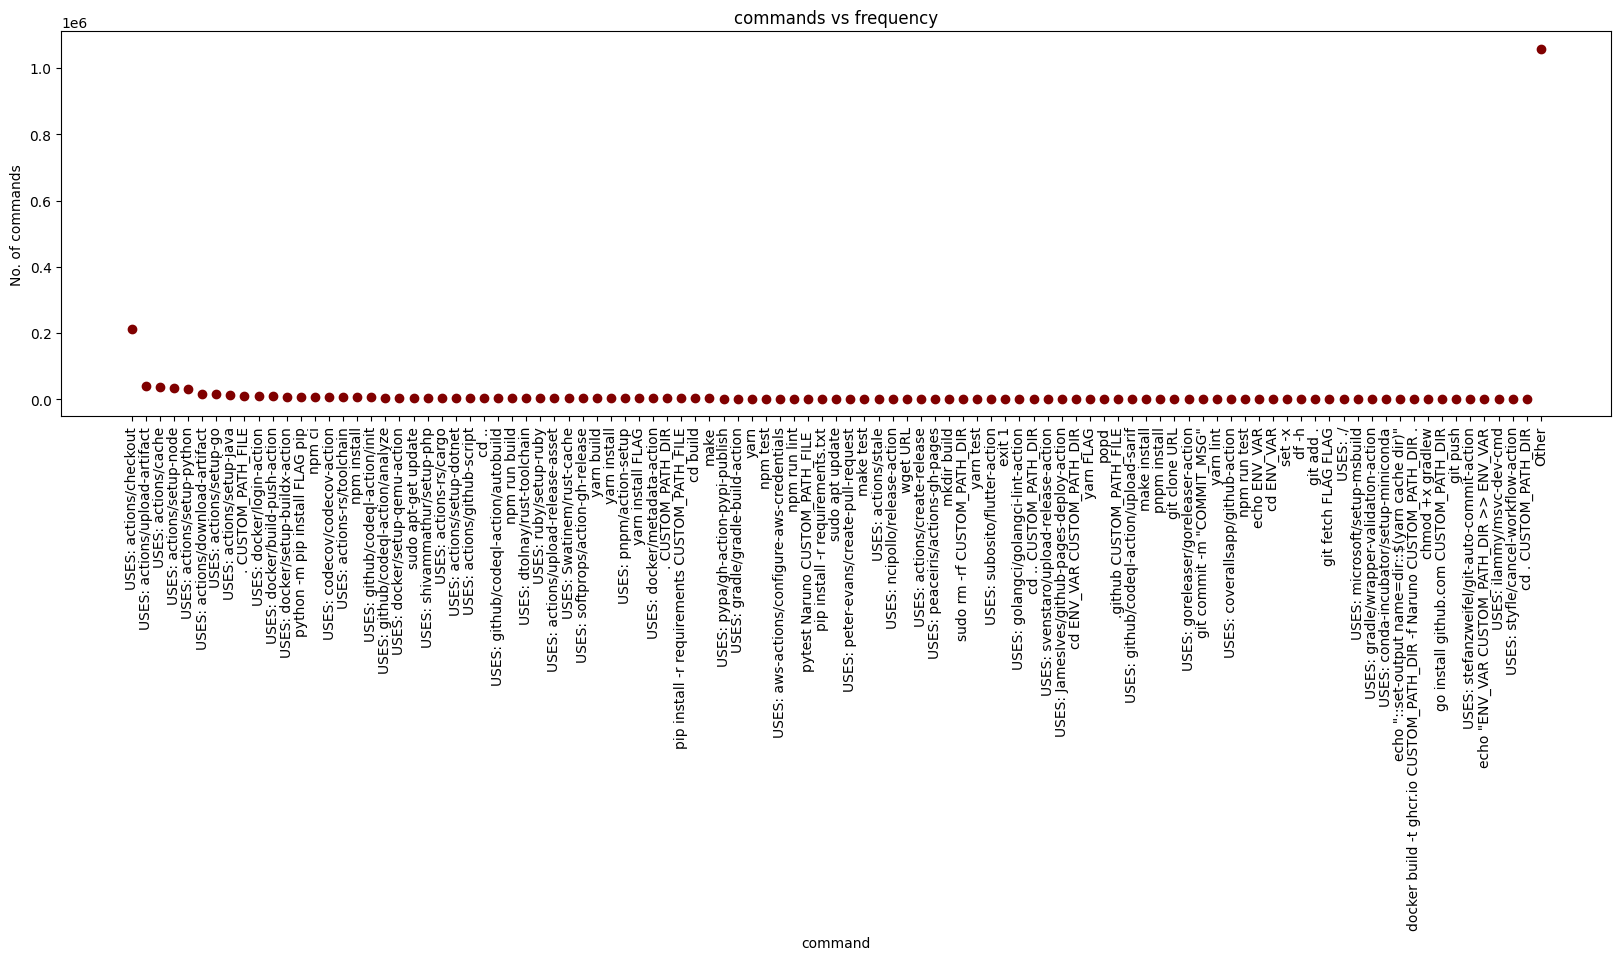

In [42]:
NUM_OF_TOP_COMMANDS = 100
plot_commands(commands_count, NUM_OF_TOP_COMMANDS, "abstracted_commands_plot.png")

In [44]:
from collections import defaultdict

with open("command_count.txt", "w") as file:
    for key, value in commands_count.items():
        if value > 5:
            file.write(f"{key}: {value}\n")

In [49]:
def count_by_first_word(commands):
    """
    Count occurrences of commands by their first word.
    """
    first_word_counts = defaultdict(int)

    for command, count in commands.items():
        first_word = command.split()[0]
        if first_word == "sudo":
            first_word = command.split()[1]
        first_word_counts[first_word] += count

    return first_word_counts


first_word_counts = count_by_first_word(commands_count)

sorted_first_word_counts = sorted(
    first_word_counts.items(), key=lambda x: x[1], reverse=False
)

for first_word, count in sorted_first_word_counts:
    print(f"{first_word}: {count}")

ENV_VAR=$($(echo: 1
ENV_VAR="${{steps.version.outputs.VERSION}}": 1
ENV_VAR32="URL: 1
ENV_VAR64="URL: 1
update-index: 1
InstallZephirParser: 1
Enable-PhpExtension: 1
.\zephir.bat: 1
EnableTestExtension: 1
PrintLogs: 1
PrintEnvVars: 1
PrintDirectoriesContent: 1
PrintBuildDetails: 1
SKIP_BUILD=y: 1
SKIP_UP=y: 1
version="${version_majminpat}-${{: 1
LDFLAGS="${{: 1
bricks: 1
alsa-utils: 1
espeak: 1
ev3dev-media: 1
ev3dev-mocks: 1
libasound2-plugin-ev3dev: 1
libgrx-3.0-dev: 1
libi2c-dev: 1
libumockdev0: 1
uthash-dev: 1
xfonts-100dpi: 1
RELEASE_NAME=db3-ENV_VAR: 1
DB3_BINARY_NAME=db3: 1
FTS_LOG_FILE=$(docker: 1
#Set: 1
VERSION=1.0.${{github.run_number}}-ENV_VAR.commit-ENV_VAR::7}: 1
IMAGE_ID=ubuntu-2004-sgx-2.17.1: 1
IMAGE_ID=ubuntu-1804-sgx-2.17.1: 1
IMAGE_ID=ubuntu-2004-sgx-dcap-1.14: 1
IMAGE_ID=ubuntu-1804-sgx-dcap-1.14: 1
sealctl: 1
FLINT_JLL_VERSION=$(grep: 1
FLINT_JLL_SONAME=$(grep: 1
FLINT_JLL_MAJOR=$(echo: 1
FLINT_JLL_MINOR=$(echo: 1
FLINT_JLL_PATCH=$(echo: 1
PR_TITLE=$(echo: 1
BV_PA

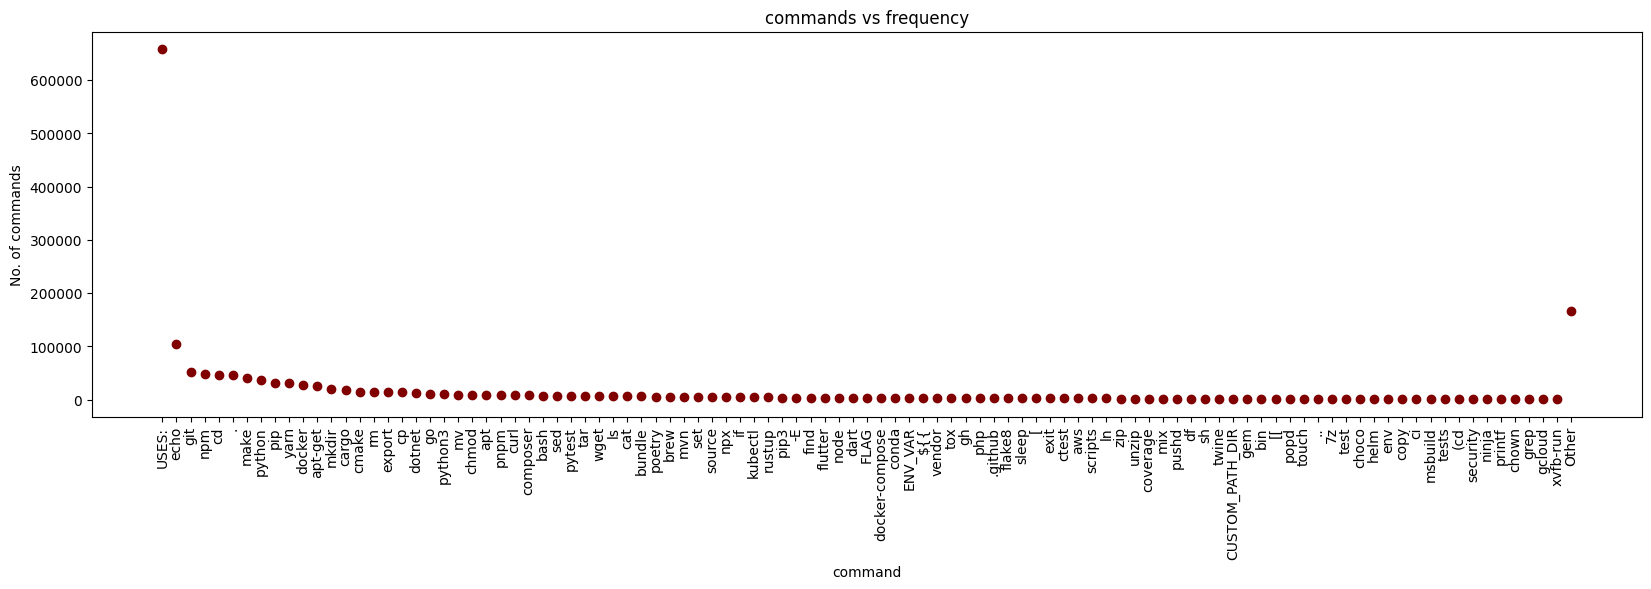

In [50]:
plot_commands(
    dict(sorted_first_word_counts),
    NUM_OF_TOP_COMMANDS=100,
    file_name="first_word_commands_plot.png",
)

## Test on different normalized crons


In [39]:
from cron_descriptor import get_description
from gsppy.gsp import GSP


def simplify_crons(cron_human):
    if cron_human.startswith("At"):
        if cron_human.endswith("AM") or cron_human.endswith("PM"):
            return "Every day"
        cron_human_split = cron_human.split(",")
        if len(cron_human_split) == 2:
            if cron_human_split[1].startswith(" only on"):
                and_count = cron_human_split[1].count("and")
                if and_count == 0:
                    return "Every week"
                else:
                    return f"{and_count+1} times a week"
            if cron_human_split[1].startswith(" every"):
                return cron_human_split[1].strip()
            if cron_human_split[1].endswith("of the month"):
                return "Every month"
    if cron_human.startswith("Every"):
        return cron_human

    return "Other"


transactions_by_scheduled_trigger_normalize = dict()

for gha_workflow_sequence in gha_workflow_sequences:
    sequence = gha_workflow_sequence["sequence"]
    triggers = gha_workflow_sequence["triggers"]
    try:
        if "schedule" in triggers:
            cron = simplify_crons(get_description(triggers["schedule"][0]["cron"]))
            if cron not in transactions_by_scheduled_trigger_normalize:
                transactions_by_scheduled_trigger_normalize[cron] = []
            transactions_by_scheduled_trigger_normalize[cron].append(sequence)
    except:
        pass
len(transactions_by_scheduled_trigger_normalize)

for cron, trigger_transactions in transactions_by_scheduled_trigger_normalize.items():
    print(cron)
    print(len(trigger_transactions))
    if len(trigger_transactions) > 10:
        trigger_result = GSP(trigger_transactions).search(0.9)
        display(trigger_result)
        print("_" * 20)

Every week
11437


KeyboardInterrupt: 